<h1>Assignment 4</h1>
<ol><li><p>I first dataset I chose is from Kaggle.com. It is the Pima Indians Diabetes dataset. I am interested in this dataset because my father has suffered with Diabetes since he was a child.</p><a target="_blank" href="https://www.kaggle.com/uciml/pima-indians-diabetes-database">https://www.kaggle.com/uciml/pima-indians-diabetes-database</a></li>

<li><p>For the second dataset, I chose Heart Failure Predictions</p>
    <a href='https://www.kaggle.com/andrewmvd/heart-failure-clinical-data?select=heart_failure_clinical_records_dataset.csv'>https://www.kaggle.com/andrewmvd/heart-failure-clinical-data?select=heart_failure_clinical_records_dataset.csv</a></li>
<li><p>For the third dataset, I chose the Breast Cancer </p><a href="https://www.kaggle.com/uciml/breast-cancer-wisconsin-data">https://www.kaggle.com/uciml/breast-cancer-wisconsin-data</a></li>
</ol>
    

### Imports

In [34]:
from sklearn.cluster import KMeans
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Exercise 1: Clustering, Bisecting k-Means

In [2]:
def feature_normalization(X):
    # compute mean and stdev over axis 0, the feature vector (down the column)
    mean = np.mean(X,0)
    stddev = np.std(X,0)
    
    # elementwise difference
    diff = np.subtract(X,mean)
    
    # elementwise division
    normalized = np.divide(diff,stddev)
    
    # for testing
    # for each feature, stddev should be 1 and mean should be 0
    #print("stddev of normalized", np.std(normalized,0))    
    #print("mean of normalized", np.mean(normalized,0))    
    
    return normalized  

def kmeans_2_clusters(X, max_iter, random_state = 42):
    km = KMeans(n_clusters=2, max_iter = max_iter, random_state=random_state)
    km.fit(X)
    return km.labels_

def bkmeans(X, k, max_iter, random_state = 42):
    # K should be greater than 1, otherwise it can be considered already a cluster
    assert k>1
    
    # Step 1, initialize by dividing in to two clusters
    clusters = kmeans_2_clusters(X, max_iter)
    
    # Initialize counter to these two clusters
    cluster_counter = 2
    
    # Step 2, Iterate until reached num of clusters desired
    while cluster_counter < k:
        # Get largest cluster
        cluster_ids, cluster_counts = np.unique(clusters, return_counts = True)
        largest_cluster_index = np.argmax(cluster_counts)
        
        # This is actually unnecessary because the id always matches the index
        largest_cluster_id = cluster_ids[largest_cluster_index]
        
        # Get indices of elements in the largest cluster 
        indices = np.nonzero(clusters == largest_cluster_id)[0]
        
        # Get values of subcluster for use in Kmeans
        values_largest_cluster = X[indices]
        
        # Split subcluster into two smaller clusters
        subcluster_labels = kmeans_2_clusters(values_largest_cluster, max_iter)
        
        # Get indices of new subcluster that is mapped to 0 (arbitrary, can choose 0 or 1)
        subcluster_label_indices = np.nonzero(subcluster_labels == 0)[0]

        # Map indices of new subcluster back to the main cluster array
        original_indices = indices[subcluster_label_indices]
        
        # Update main cluster array with new subcluster assignments
        clusters[original_indices] = cluster_counter
        
        # Increment counter
        cluster_counter += 1
    
    return clusters
    

# Exercise 2: Non-linear Dimensionality Reduction

<p>The algorithm can be implemented with gradient descent using the following steps:</p>
<ol><li>Start with a random two-dimensional layout Y of points (Y is a n × 2 matrix).</li>
    <li>Compute the stress E of Y . See slide 47 of Lecture 12 for the formula.</li>
    <li>If E < ε, or if the maximum number of iterations iter has been reached, stop.</li>
    <li>For each yi of Y , find the next vector yi(t + 1) based on the current yi(t). See slide 48 of lecture 12</li><li>Go to Step 2.</li></ol>


In [3]:
def get_distance_matrix(X, Y):
    """ Create distance matrix 
    Note:
        1. I used this during assignment 1. The algorithm was found here and adapted to include
        the sqrt,
        
        https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c
        
        It is a no loop solution, which means it can handle the matrices in
        one line of code rather than having to iterate over the rows of one
        matrix
    """
    # perform operation in parts due to tiny numbers causing error with sqrt
    eu1 = -2 * np.dot(Y, X.T) + np.sum(X**2, axis=1) + np.sum(Y**2, axis=1)[:, np.newaxis]
    
    # replace tiny numbers with 0
    eu1 = np.where(np.absolute(eu1)<1e-10,0,eu1)
    
    # return sqrt of 'clean' matrix
    return np.sqrt(eu1)

def get_c(X):
    # C is the sum of all elements of the upper triangular distance matrix
    return np.sum(np.triu(X))

def sammon(hd_matrix, max_iter=20, error_threshold=.001, learning_rate=.3):
    
    # Compute the high dimensional distance matrix
    hd_delta_matrix = get_distance_matrix(hd_matrix, hd_matrix)

    # Get the constant c
    c = get_c(hd_delta_matrix)
    
    # Initialize a random reduced dimensionmatrix
    original_reduced_matrix = reduced_matrix = np.random.rand(len(hd_matrix),2)
        
    for curr_iter in range(1,max_iter):
        reduced_delta_matrix = get_distance_matrix(reduced_matrix, reduced_matrix)
        yitp1 = gradient(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, learning_rate, c)
        reduced_matrix = yitp1
        if stress(c, reduced_delta_matrix, hd_delta_matrix) < error_threshold:
            break
        
    return reduced_matrix

def gradient(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, learning_rate, c ):
    return reduced_matrix - learning_rate * pd1(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c)/pd2(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c)
    
# The first partial derivative. I did this in steps to aid me in debugging.
def pd1(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c):
    a = (-2/c)
    
    b = hd_delta_matrix - reduced_delta_matrix
    
    cc = reduced_delta_matrix * hd_delta_matrix
    
    e = special_division(b, cc)
    
    ee = e[:,:,np.newaxis]
    
    f = reduced_matrix - reduced_matrix[:,np.newaxis]
    
    g = ee*f
    
    h = np.sum(g,axis=0)

    i = a * h
    
    return i

# We should not be dividing by zero, however, this causes a runtime warning only 
# on Jupyter and only affects the elements along the diagonal (or maybe other datapoints with 0 distance)
# Therefore, this operation does not block an otherwise efficient way to compute this as a matrix operation
# We simply perform the division, ignore the warning in place, and then fix the divide by zero cells, changing
# them from nan back to 0. Then we can sum over the matrix later using numpy and avoid for loops
def special_division(numerator, denominator):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            result = numerator / denominator
            #print("d", d)
        except Warning as e:
            print('error found:', e)
    result = np.nan_to_num(result)
    return result
    
# The second partial derivative. I did this in steps to aid me in debugging.
def pd2(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c):
    a = (-2/c)
    b = hd_delta_matrix * reduced_delta_matrix
    cc = special_division(1,b)
    e = hd_delta_matrix - reduced_delta_matrix
    f = reduced_matrix - reduced_matrix[:,np.newaxis]
    f = f**2
    g = special_division(f,reduced_delta_matrix[:,:,np.newaxis])
    h = special_division( (hd_delta_matrix - reduced_delta_matrix), reduced_delta_matrix)
    i = (1+h)[:,:,np.newaxis]
    j = g * i
    e = e[:,:,np.newaxis]
    k = e - j 
    cc = cc[:,:,np.newaxis]
    l = cc * k
    m = np.sum(l,axis=0)
    n = a*m
    return n

def stress(c, reduced_delta_matrix, hd_delta_matrix):
    a = (1/c)

    b = (hd_delta_matrix-reduced_delta_matrix)**2
    
    c = special_division(b, hd_delta_matrix)

    c = np.triu(c)
    
    return a * np.sum( c )

# Exercise 3: Visualization of Results

/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in m

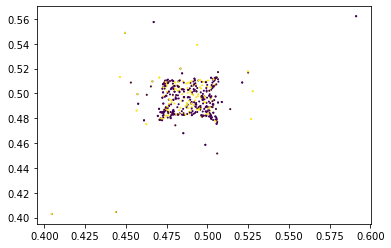

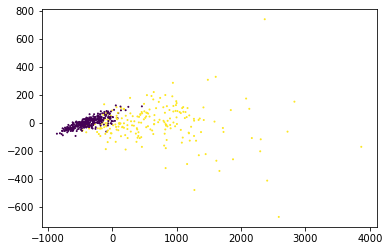

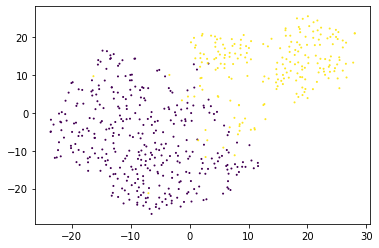

In [36]:
def data1():
    # load diabetes data
    data_diabetes = np.loadtxt('./diabetes.csv',delimiter=',',skiprows=1)
    X_diabetes = data_diabetes[:, 0:-1]
    y_diabetes = data_diabetes[:, -1]
    #print(y_diabetes.shape, y_diabetes)

    # Normalize Data
    Xn_diabetes = feature_normalization(X_diabetes)
    
    # Get Clusters
    clusters_diabetes = bkmeans(Xn_diabetes, 10, 10)
    sammon_diabetes = sammon(Xn_diabetes, max_iter=10, error_threshold=.3, learning_rate=.3)

    #print("A4, Diabetes, Clusters\nclusters.shape",clusters_diabetes.shape,"\nclusters",clusters_diabetes)
    #print("A4, Diabetes, Sammon\nreduced_matrix.shape",sammon_diabetes.shape,"\nreduced_matrix",sammon_diabetes)
    
    
    
    # load heart data
    data_heart = np.loadtxt('./heart_failure_clinical_records_dataset.csv',delimiter=',',skiprows=1)
    X_heart = data_heart[:, 0:-1]
    y_heart = data_heart[:, -1]
    #print(y_heart.shape, y_heart)
    
    # Normalize Data
    Xn_heart = feature_normalization(X_heart)
    
    # Get Clusters
    clusters_heart = bkmeans(Xn_heart, 10, 10)
    
    # Get Mapped lower dimensional matrix
    sammon_heart = sammon(Xn_heart, max_iter=10, error_threshold=.3, learning_rate=.3)
    
    #print("A4, Heart Failure, Clusters\nclusters.shape",clusters_heart.shape,"\nclusters",clusters_heart)
    #print("A4, Heart Failure, Sammon\nreduced_matrix.shape",sammon_heart.shape,"\nreduced_matrix",sammon_heart)
    
    
    
    # load Breast Cancer data
    data_cancer = np.loadtxt('./data.csv',delimiter=',',skiprows=1)
    X_cancer = data_cancer[:, 2:]
    y_cancer = data_cancer[:, 1]
    #print(y_cancer.shape, y_cancer)
    
    # Normalize Data
    Xn_cancer = feature_normalization(X_cancer)
    
    # Get Clusters
    clusters_cancer = bkmeans(Xn_cancer, 10, 10)
    #print("A4, Breast Cancer\nclusters.shape",clusters_cancer.shape,"\nclusters",clusters_cancer)
    
    # Get Mapped lower dimensional matrix
    sammon_cancer = sammon(Xn_cancer, max_iter=10, error_threshold=.3, learning_rate=.3)
    #print("A4, Breast Cancer\nreduced_matrix.shape",sammon_cancer.shape,"\nreduced_matrix",sammon_cancer)
    
    pca_cancer = PCA(n_components=2)
    pca_cancer = pca_cancer.fit_transform(X_cancer)
    
    tsne_cancer = TSNE(n_components=2).fit_transform(Xn_cancer)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(sammon_cancer[:,0], sammon_cancer[:,1], s=1, c=y_cancer)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(pca_cancer[:,0], pca_cancer[:,1], s=1, c=y_cancer)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(tsne_cancer[:,0], tsne_cancer[:,1], s=1, c=y_cancer)

data1()


def ex3():
    print("A4, EX3")
    
    # load data
    # import some data to play with
    iris = datasets.load_iris()
    X = iris.data  # we only take the first two features.
    y = iris.target

    # Normalize Data
    Xn = feature_normalization(X)
    #Xn = X
    
    # Get Clusters
    reduced_matrix = sammon(Xn,max_iter=4)
    
    
    # plot boundary with support vector    
    fig = plt.figure()
    fig.suptitle("Ex A, Decision boundary with support vector")
    ax = fig.add_subplot(1, 1, 1)

    # plot support vectors
    ax.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=1, c = 1)
